In [75]:
import pandas as pd

pd.Index([1,2,3]).difference(pd.Index([2,3,4]))

Index([1], dtype='int64')

In [213]:
import re
import sys
import requests
import numpy as np
import pandas as pd
from pathlib import Path
from urllib import parse
from pytz.exceptions import NonExistentTimeError

sys.path.append(str(Path.cwd().parent / "scripts"))

from build_base import build_sp_register, dst_start_dates, dst_end_dates

year_file = Path.cwd().parent / "data" / "year-ahead-constraint-limits.csv"
two_year_file = Path.cwd().parent / "data" / "24-months-ahead-constraint-limit_060924.csv"





ds = []
from tqdm import tqdm

year = '2024'

for day in tqdm(pd.date_range(f'{year}-01-01', f'{year}-10-08')):
    day = day.strftime("%Y-%m-%d")

    sp_register = build_sp_register(day)
    date_range = sp_register.index

    df = get_boundary_flow_day(date_range)
    ds.append(df)

pd.concat(ds).to_csv(f'constraint_limits_{year}.csv')

  9%|▉         | 25/282 [00:09<01:24,  3.05it/s]

No data found for 2024-01-25


 16%|█▌        | 45/282 [00:16<01:19,  2.96it/s]

No data found for 2024-02-14


 16%|█▋        | 46/282 [00:17<01:16,  3.10it/s]

No data found for 2024-02-15


 17%|█▋        | 49/282 [00:18<01:18,  2.98it/s]

No data found for 2024-02-18


 34%|███▍      | 96/282 [00:35<01:04,  2.88it/s]

No data found for 2024-04-04


100%|██████████| 282/282 [01:44<00:00,  2.70it/s]


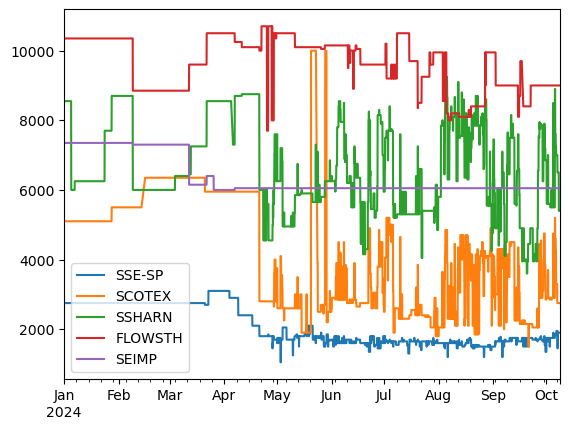

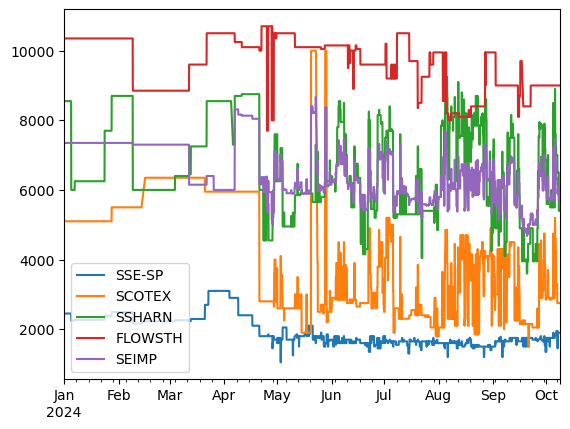

In [319]:
df = pd.read_csv('constraint_limits_2024.csv', index_col=0, parse_dates=True)


<Axes: >

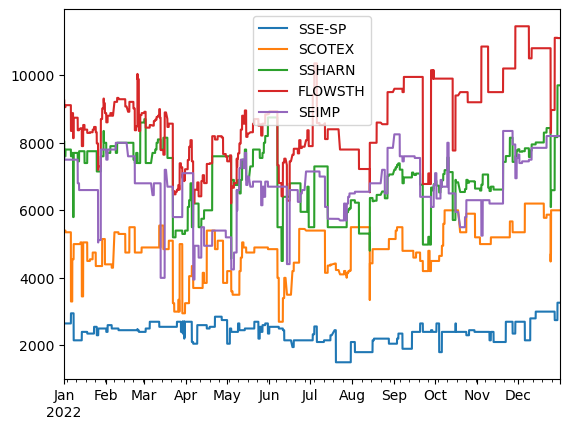

In [309]:
df.plot()

In [141]:
from io import StringIO
from tqdm import tqdm

filler = '060924'
template = 'https://api.neso.energy/dataset/d515b4a9-60a1-489c-a126-004efc04f121/resource/3c359e33-3dac-4bdd-87d1-efbf4cbc2f07/download/24-months-ahead-constraint-limit_{}.csv'

response = requests.get(template.format(filler))
df = pd.read_csv(StringIO(response.text))
print(df.head())

for date in tqdm(pd.date_range('2023-10', '2025', freq='d')):
    url = template.format(date.strftime('%y%m%d'))
    response = requests.get(url)
    print(date, response.status_code)
    df = pd.read_csv(StringIO(response.text))
    print(url)
    print(df.head())

    break
    if response.status_code != 200:
        print(date)
        break



response = requests.get(url.format(filler))
print(response.status_code)

df

   YEAR  Week No  DRESHEX1  ESTEX  FLOWSTH  GM+ SNOW5A  NKILGRMO  SCOAST2  \
0  2024       40      6250   5650    10150        4900      2090     5550   
1  2024       41      6000   5050    11050        4900      2070     5750   
2  2024       42      6750   5550    11100        4750      2140     5575   
3  2024       43      7800   5550    11100        4100      2190     5550   
4  2024       44      8675   5600    10300        2750      2250     5500   

   SCOTEX ASACS  SEIMPPR2  SSE+GRM  SSEN-S  SSE-SP2  SSHARN3 (With HVDC)  
0          4980      6400     2250    2100     2000                 8250  
1          5130      6250     2290    1980     2010                 7800  
2          5150      6400     2300    2000     2200                 7600  
3          5200      6350     2340    2180     2270                 7450  
4          5350      6200     2380    2280     2250                 8650  


  0%|          | 0/459 [00:01<?, ?it/s]

2023-10-01 00:00:00 200
https://api.neso.energy/dataset/d515b4a9-60a1-489c-a126-004efc04f121/resource/3c359e33-3dac-4bdd-87d1-efbf4cbc2f07/download/24-months-ahead-constraint-limit_231001.csv
   YEAR  Week No  DRESHEX1  ESTEX  FLOWSTH  GM+ SNOW5A  NKILGRMO  SCOAST2  \
0  2024       40      6250   5650    10150        4900      2090     5550   
1  2024       41      6000   5050    11050        4900      2070     5750   
2  2024       42      6750   5550    11100        4750      2140     5575   
3  2024       43      7800   5550    11100        4100      2190     5550   
4  2024       44      8675   5600    10300        2750      2250     5500   

   SCOTEX ASACS  SEIMPPR2  SSE+GRM  SSEN-S  SSE-SP2  SSHARN3 (With HVDC)  
0          4980      6400     2250    2100     2000                 8250  
1          5130      6250     2290    1980     2010                 7800  
2          5150      6400     2300    2000     2200                 7600  
3          5200      6350     2340    2180   

200


,YEAR,Week No,DRESHEX1,ESTEX,FLOWSTH,GM+ SNOW5A,NKILGRMO,SCOAST2,SCOTEX ASACS,SEIMPPR2,SSE+GRM,SSEN-S,SSE-SP2,SSHARN3 (With HVDC)
0,2024,40,6250,5650,10150,4900,2090,5550,4980,6400,2250,2100,2000,8250
1,2024,41,6000,5050,11050,4900,2070,5750,5130,6250,2290,1980,2010,7800
2,2024,42,6750,5550,11100,4750,2140,5575,5150,6400,2300,2000,2200,7600
3,2024,43,7800,5550,11100,4100,2190,5550,5200,6350,2340,2180,2270,7450
4,2024,44,8675,5600,10300,2750,2250,5500,5350,6200,2380,2280,2250,8650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2026,36,99999,4900,10500,5300,2310,4450,4600,5750,2330,2038,2213,7100
101,2026,37,99999,4500,10850,4800,2310,4550,4600,7500,2320,2038,2213,7050
102,2026,38,99999,5475,9800,3875,2310,5350,4650,7275,2250,2038,2213,6150
103,2026,39,99999,5475,9425,3675,2310,5350,4700,7300,2280,2038,2213,6100


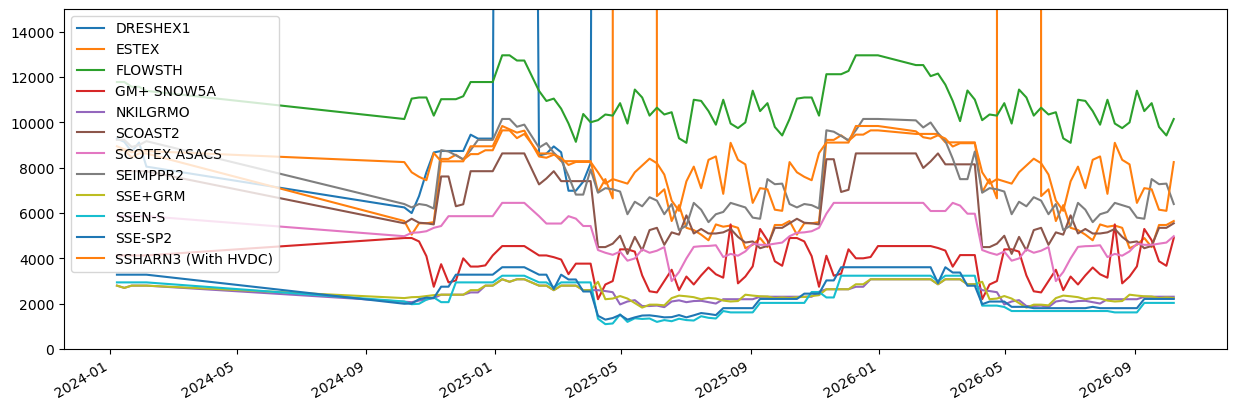

In [143]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

a.drop(columns=['YEAR', 'Week No']).sort_index().plot(ax=ax)
ax.set_ylim(0, 15000)

plt.show()

In [6]:
import sys
import pandas as pd
from pathlib import Path

sys.path.append(str(Path.cwd().parent / "scripts"))

from build_flow_constraints import get_boundary_flow_day
from _constants import build_sp_register

constraints_base = pd.read_csv(
    Path.cwd().parent / "data" / "flow_constraints_2023.csv",
    index_col=0,
    parse_dates=True
)

day = '2024-10-09'
date_register = build_sp_register(day)
date_range = date_register.index

<Axes: xlabel='date'>

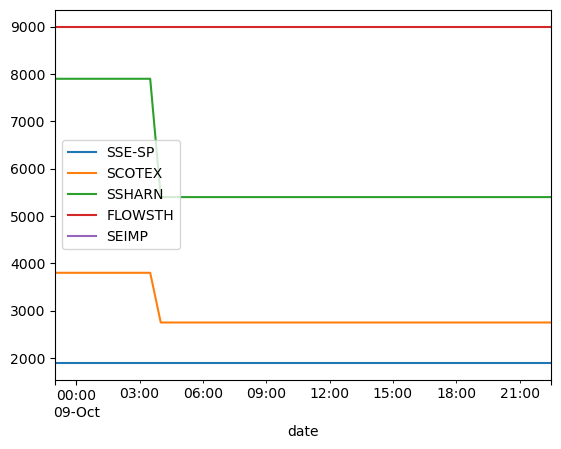

In [11]:
# constraints_base.loc[date_range]
df = get_boundary_flow_day(date_range)
df.plot()

<Axes: xlabel='date'>

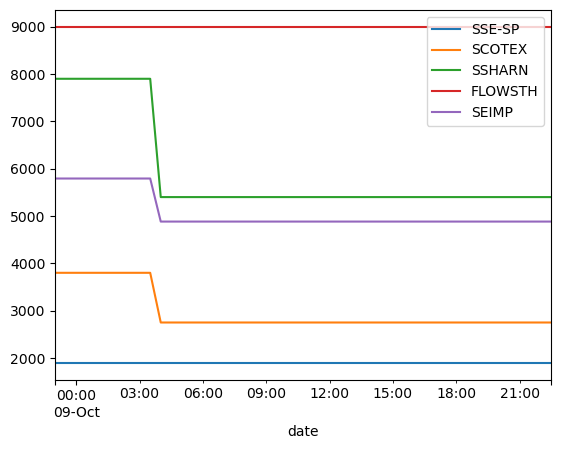

In [13]:
# method does not work if at any timesteps data is missing for all boundaries
assert not df.isna().all(axis=1).any()

df = df.fillna(
    pd.DataFrame(
            df.mean(axis=1).values[:, None] * constraints_base.mean().values / constraints_base.mean().mean(),
            index=df.index,
            columns=df.columns
        )
    )

df.plot()

<Axes: >

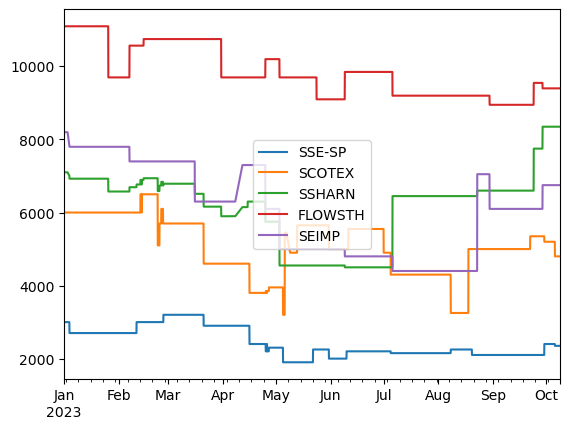

In [8]:
constraints_base.plot()